In [67]:
# Initialize Otter
import otter
grader = otter.Notebook("lab04.ipynb")

### Content Warning
This lab includes an analysis of crime in Berkeley. If you feel uncomfortable with this topic, **please contact your TA or the instructors, or reach out via the [Summer 2024 Accommodations Form](https://docs.google.com/forms/d/e/1FAIpQLSe637FZSvtd0zRtvs3jsTvHojF2HH90D_YR84YWIaRAaNxc5w/viewform).**


# Lab 04: Regex and EDA
## Due Sunday, June 30th, 11:59 PM PT

In this lab, you will be working on visualizing a dataset from the City of Berkeley containing data on calls to the Berkeley Police Department. Information about the dataset can be found [at this link](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).


To receive credit for a lab, answer all questions correctly and submit before the deadline.

You must submit this assignment to Gradescope by the on-time deadline, **Sunday, June 30th, 11:59 PM PT**. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to late-night requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to contact staff for submission support.

**This lab contains three written questions**, which will be graded based on completion and coherence. After submitting this assignment to the Lab 04 Coding assignment on Gradescope, Gradescope will automatically submit the PDF from this file to the Lab 04 Written assignment.

### Lab Walkthrough
In addition to the lab notebook, we have also released a prerecorded walkthrough video of the lab. This playlist includes a walkthrough for every question in the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.
<br>

**Note:** This video was recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but the content is largely identical. The key difference is that we are using the most updated 2022 dataset for the Berkeley crime data, not the 2021 dataset.

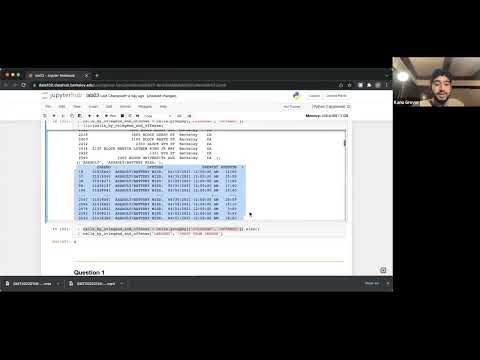

In [68]:
from IPython.display import YouTubeVideo
YouTubeVideo("LcIXTx49o2A", list = 'PLQCcNQgUcDfrG1xueBsgwDy0x5vQmi5j0', listType = 'playlist')

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

---
### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, and common pandas errors.

---
### Setup

In this lab, we'll perform Exploratory Data Analysis and learn some preliminary tips for working with `matplotlib` (a Python plotting library). In the cell below, we configure a custom default figure size. Virtually every default aspect of `matplotlib` [can be customized](https://matplotlib.org/users/customizing.html). `matplotlib` will formally be taught in lectures 7 and 8.

In [69]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: Acquire the Data

Here, we start by acquiring the data that this lab is based on. **Please don't worry about understanding all the code in this section**; the steps shown here are out of scope and provided here for student interest!

**1. Obtain data**<br/>
To retrieve the dataset, we will use the `ds100_utils.download_lab3_data` utility, a helper function that Data 100 staff created. You can see how this is implemented by opening the file `ds100_utils.py` on the left.

In [70]:
# Run this cell to download the data, no further action is needed.
from ds100_utils import download_lab3_data

dest_path = download_lab3_data()
print(f'Located at {dest_path}')

Using cached version that was downloaded (UTC): Fri Jan 24 00:22:21 2025
Located at data\lab03_data_sp24.zip


**2. Unzip file**<br/>
We will now directly unzip the ZIP archive and start working with the uncompressed files.

In [71]:
# Run this cell to unzip the data, no further action is needed.
my_zip = zipfile.ZipFile(dest_path, 'r')
my_zip.extractall('data')

There is no single right answer regarding whether to work with compressed files in their compressed state or to uncompress them on disk permanently. For example, if you need to work with multiple tools on the same files or write many notebooks to analyze them—and they are not too large—it may be more convenient to uncompress them once. But you may also have situations where you find it preferable to work with the compressed data directly.  

`Python` gives you tools for both approaches, so it can be helpful to know how to perform both tasks in order to choose the one that best suits the problem at hand.

**3. View files**

Now, we'll use the `os` package to list all files in the `data` directory. `os.walk()` recursively traverses the directory, and `os.path.join()` creates the full pathname of each file.

If you're interested in learning more, check out the `Python3` documentation pages for `os.walk` ([link](https://docs.python.org/3/library/os.html#os.walk)) and `os.path.join` ([link](https://docs.python.org/3/library/os.path.html#os.path.join)).

We use `Python3` [format strings](https://docs.python.org/3/tutorial/inputoutput.html) to nicely format the printed variables `dpath` and `fpath`.

In [72]:
# Run this cell to view the content in the zip file, no further action is needed.
import os

for root, directories, filenames in os.walk('data'):
    # first, print out all directories
    for directory in directories:
        dpath = os.path.join(root, directory)
        print(f"d {dpath}")
        
    # next, print out all files
    for filename in filenames:  
        fpath = os.path.join(root,filename)
        print(f"  {fpath}")

d data\secret
  data\Berkeley_PD_-_Calls_for_Service_2022.csv
  data\dummy.txt
  data\hello_world.py
  data\lab03_data_sp24.zip
  data\secret\do_not_readme.md


In this Lab, we'll be working with the `Berkeley_PD_-_Calls_for_Service_2022.csv` file. Feel free to check out the other files, though.

<br/>

<hr style="border: 1px solid #fdb515;" />

# Part 2: Clean and Explore the Data

Let's now load the CSV file we have into a `DataFrame`, and start exploring the data. We added a line at the top of the cell to suppress a couple of warnings related to how we use `pd.to_datetime` here, but you need not worry about that.

In [73]:
# %%capture --no-stdout

# Run this cell to read the data into a DataFrame and do some initial formatting, no further action is needed.
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service_2022.csv")
calls['EVENTTM'] = pd.to_datetime(calls['EVENTTM']).dt.strftime('%H:%M:%S %p')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22964\555453042.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  calls['EVENTTM'] = pd.to_datetime(calls['EVENTTM']).dt.strftime('%H:%M:%S %p')


In [74]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,22036516,THEFT FROM AUTO,08/10/2022 12:00:00 AM,06:10:00 AM,LARCENY - FROM VEHICLE,3,10/13/2022 04:42:00 PM,"Berkeley, CA\n(37.86988, -122.27054)",NaN,Berkeley,CA
1,22027674,BURGLARY RESIDENTIAL,06/16/2022 12:00:00 AM,20:25:00 PM,BURGLARY - RESIDENTIAL,4,10/13/2022 04:42:00 PM,"1700 BLOCK OXFORD ST\nBerkeley, CA\n(37.87674,...",1700 BLOCK OXFORD ST,Berkeley,CA
2,22023993,VANDALISM,05/25/2022 12:00:00 AM,08:00:00 AM,VANDALISM,3,10/13/2022 04:42:00 PM,"2400 BLOCK 8TH ST\nBerkeley, CA\n(37.86206, -1...",2400 BLOCK 8TH ST,Berkeley,CA
3,22026547,DISTURBANCE,06/10/2022 12:00:00 AM,21:35:00 PM,DISORDERLY CONDUCT,5,10/13/2022 04:42:00 PM,"1300 BLOCK HEARST AVE\nBerkeley, CA\n(37.87133...",1300 BLOCK HEARST AVE,Berkeley,CA
4,22018126,ASSAULT/BATTERY FEL.,04/20/2022 12:00:00 AM,15:31:00 PM,ASSAULT,3,10/13/2022 04:42:00 PM,"3000 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.855...",3000 BLOCK SHATTUCK AVE,Berkeley,CA


We see that the fields include a case number, the offense type, the date and time of the offense, the "CVLEGEND" which appears to be related to the offense type, a "CVDOW" which has no apparent meaning, the date the record was added to the database, and the location spread across four fields. We can read more about each field from the City of Berkeley's [open dataset webpage](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

Let's also check some basic information about this `DataFrame` using the `pandas.DataFrame.info` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)) and `pandas.DataFrame.describe` methods ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)).

In [75]:
# df.info() displays name and type of each column, and
# number of non-null entries in each column
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4490 entries, 0 to 4489
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CASENO          4490 non-null   int64 
 1   OFFENSE         4490 non-null   object
 2   EVENTDT         4490 non-null   object
 3   EVENTTM         4490 non-null   object
 4   CVLEGEND        4490 non-null   object
 5   CVDOW           4490 non-null   int64 
 6   InDbDate        4490 non-null   object
 7   Block_Location  4490 non-null   object
 8   BLKADDR         4476 non-null   object
 9   City            4490 non-null   object
 10  State           4490 non-null   object
dtypes: int64(2), object(9)
memory usage: 386.0+ KB


Note that the BLKADDR column only has 4476 non-null entries, while the other columns all have 4490 entries. This is because the `.info()` method only counts non-null entries.

In [76]:
calls.describe()

,CASENO,CVDOW
count,4.490000e+03,4490.000000
mean,2.204229e+07,3.075724
std,2.222561e+04,1.976035
min,2.200110e+07,0.000000
25%,2.202749e+07,1.000000
50%,2.203642e+07,3.000000
75%,2.204490e+07,5.000000
max,2.209134e+07,6.000000


Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the `DataFrame`. However, we still need more information about what each column represents. Let's explore the data further in Question 1.

Before we go over the fields to deduce their meanings, the cell below will verify that all the events happened in Berkeley by grouping on the `City` and `State` columns. You should see that all of our data falls into one group.

In [77]:
# .size() returns the number of rows in each DataFrameGroupBy object
calls.groupby(["City", "State"]).size()

City      State
Berkeley  CA       4490
dtype: int64

When we called `.head()` on the `DataFrame` `calls`, it seemed like `OFFENSE` and `CVLEGEND` both contained information about the type of event reported. What is the difference in meaning between the two columns? One way to probe this is to look at the `value_counts` for each `Series`.

In [78]:
calls['OFFENSE'].value_counts().head(10)

OFFENSE
THEFT MISD. (UNDER $950)    660
THEFT FELONY (OVER $950)    454
BURGLARY AUTO               446
DISTURBANCE                 437
VEHICLE STOLEN              332
THEFT FROM AUTO             294
VANDALISM                   264
ASSAULT/BATTERY MISD.       249
BURGLARY RESIDENTIAL        244
BURGLARY COMMERCIAL         174
Name: count, dtype: int64

In [79]:
calls['CVLEGEND'].value_counts().head(10)

CVLEGEND
LARCENY                   1127
BURGLARY - VEHICLE         446
DISORDERLY CONDUCT         437
ASSAULT                    344
MOTOR VEHICLE THEFT        332
LARCENY - FROM VEHICLE     294
VANDALISM                  264
BURGLARY - RESIDENTIAL     244
FRAUD                      209
BURGLARY - COMMERCIAL      174
Name: count, dtype: int64

It seems like `OFFENSE` is more specific than `CVLEGEND`, e.g., "LARCENY" vs. "THEFT FELONY (OVER $950)". If you're unfamiliar with the term, "larceny" is a legal term for theft of personal property.

To get a sense of how many sub-categories there are for each `OFFENSE`, we will set `calls_by_cvlegend_and_offense` equal to a multi-indexed `Series` where the data is first indexed on the `CVLEGEND` and then on the `OFFENSE`, and the data is equal to the number of offenses in the database that match the respective `CVLEGEND` and `OFFENSE`. As you can see, `calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]` returns `13` which means there are 13 instances of larceny with offense of type "THEFT FROM PERSON" in the database.

In [80]:
calls_by_cvlegend_and_offense = calls.groupby(["CVLEGEND", "OFFENSE"]).size()
calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]

13

<br>

---

## Question 1

In the cell below, set `answer1` equal to a `list` of strings corresponding to the possible values for `OFFENSE` when `CVLEGEND` is "LARCENY". You can type the answer manually, or you can create an expression that automatically extracts the names.


In [81]:
answer1 = calls[calls["CVLEGEND"] == "LARCENY"]["OFFENSE"].unique().tolist()

In [82]:
grader.check("q1")

q1 results: All test cases passed!

<br/>

<hr style="border: 1px solid #fdb515;" />

# Part 3: Visualize the Data


### `Matplotlib` demo

You've seen some `matplotlib` in this class already (in homework 1), but now we will explain how to work with the object-oriented plotting API mentioned in this [matplotlib.pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html). In `matplotlib`, plotting occurs on a set of `Axes` that are associated with a `Figure`. An analogy is that on a blank canvas (`Figure`), you choose a location to plot (`Axes`) and then fill it in (plot).

There are two approaches to labeling and manipulating figure contents, which we'll discuss below. Approach 1 is closest to the plotting paradigm of MATLAB, the namesake of `matplotlib`; Approach 2 is also common because many `matplotlib`-based packages (such as `seaborn`) explicitly return the current set of axes after plotting data. Both are essentially equivalent, and at the end of this class, you'll be comfortable with both. 

**Approach 1**: `matplotlib` will auto-plot onto the current set of `Axes` or (if none exists) create a new figure/set of default axes. You can plot data using methods from `plt`, which is shorthand for the `matplotlib.pyplot` package. Then subsequent `plt` calls all edit the same set of default-created axes.

**Approach 2**:  
After creating the initial plot, you can also use `plt.gca()` to explicitly get the current set of axes and then edit those specific axes using axes methods. Note the method naming is slightly different!

`pandas` also offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method, which uses `matplotlib` under the hood. For now, we'll focus on `matplotlib` itself so you get used to the syntax, but just know that convenient `pandas` plotting methods exist for your own future data science exploration.

Below, we show both approaches by generating a horizontal bar plot to visually display the value counts for `CVLEGEND`. See the `barh` [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html?highlight=barh#matplotlib.pyplot.barh) for more details.

Demo 1: Using plt methods to update plot


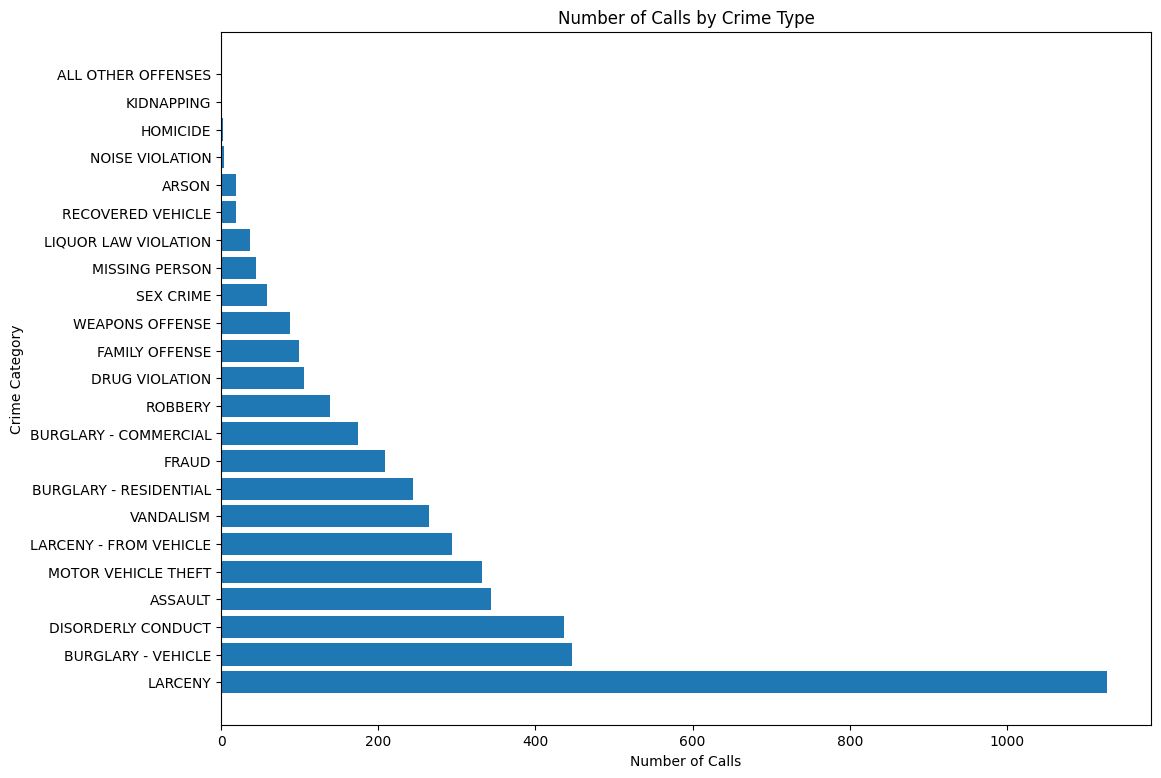

In [83]:
# DEMO CELL: assign demo to 1 or 2.
demo = 1

calls_cvlegend = calls['CVLEGEND'].value_counts()

if demo == 1:
    plt.barh(calls_cvlegend.index, calls_cvlegend) # Creates figure and axes
    print(f"Demo {demo}: Using plt methods to update plot")
    plt.ylabel("Crime Category")               # Uses most recently plotted axes
    plt.xlabel("Number of Calls")
    plt.title("Number of Calls by Crime Type")
elif demo == 2:
    print(f"Demo {demo}: Using axes methods to update plot")
    plt.barh(calls_cvlegend.index, calls_cvlegend) # Creates figure and axes
    ax = plt.gca()
    ax.set_ylabel("Crime Category")
    ax.set_xlabel("Number of Calls")
    ax.set_title("Axes methods: Number of Calls by Crime Type")
else:
    print("Error: Please assign the demo variable to 1 or 2.")

plt.show()


### An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that some of our plotting code cells end with a semicolon `;` or `plt.show()`. The former prevents any extra output from the last line of the cell; the latter explicitly returns (and outputs) the figure. Try adding this to your own code in the following questions!

<br>

---

## Question 2

Now it is your turn to make a plot using `matplotlib`. Let's start by transforming the data so that it is easier to work with.

The `CVDOW` field isn't named helpfully, and it is hard to see the meaning from the data alone. According to the website [linked](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) at the top of this notebook, `CVDOW` is actually indicating the day that events happened. 0->Sunday, 1->Monday ... 6->Saturday. 

### Question 2a

Add a new column `Day` to `calls` that has the string weekday (e.g., "Sunday") for the corresponding value in CVDOW. For example, if the first 3 values of `CVDOW` are `[3, 6, 0]`, then the first 3 values of the `Day` column should be `["Wednesday", "Saturday", "Sunday"]`.

**Hint:** Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) function on `calls["CVDOW"]`. Can you assign this to the new column `calls["Day"]`?

In [84]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_indices = range(7)
indices_to_days_dict = dict(zip(day_indices, days)) # Should look like {0:"Sunday", 1:"Monday", ..., 6:"Saturday"}

calls["Day"] = calls["CVDOW"].map(indices_to_days_dict)

In [85]:
grader.check("q2a")

q2a results: All test cases passed!

<br>

---
### Question 2b

Now let's look at the `EVENTTM` column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` `DataFrame`. **You should save the hour as an `int`**. The format of the `'EVENTTM'` column and some of the associated reasoning about the answer in the lab walkthrough is slightly different. However, the answer shown in the walkthrough is still applicable to the question below. 

**Hint:** Your code should only require one line. <br/>

In [86]:
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,22036516,THEFT FROM AUTO,08/10/2022 12:00:00 AM,06:10:00 AM,LARCENY - FROM VEHICLE,3,10/13/2022 04:42:00 PM,"Berkeley, CA\n(37.86988, -122.27054)",NaN,Berkeley,CA,Wednesday
1,22027674,BURGLARY RESIDENTIAL,06/16/2022 12:00:00 AM,20:25:00 PM,BURGLARY - RESIDENTIAL,4,10/13/2022 04:42:00 PM,"1700 BLOCK OXFORD ST\nBerkeley, CA\n(37.87674,...",1700 BLOCK OXFORD ST,Berkeley,CA,Thursday
2,22023993,VANDALISM,05/25/2022 12:00:00 AM,08:00:00 AM,VANDALISM,3,10/13/2022 04:42:00 PM,"2400 BLOCK 8TH ST\nBerkeley, CA\n(37.86206, -1...",2400 BLOCK 8TH ST,Berkeley,CA,Wednesday
3,22026547,DISTURBANCE,06/10/2022 12:00:00 AM,21:35:00 PM,DISORDERLY CONDUCT,5,10/13/2022 04:42:00 PM,"1300 BLOCK HEARST AVE\nBerkeley, CA\n(37.87133...",1300 BLOCK HEARST AVE,Berkeley,CA,Friday
4,22018126,ASSAULT/BATTERY FEL.,04/20/2022 12:00:00 AM,15:31:00 PM,ASSAULT,3,10/13/2022 04:42:00 PM,"3000 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.855...",3000 BLOCK SHATTUCK AVE,Berkeley,CA,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
4485,22035888,FRAUD/FORGERY,08/01/2022 12:00:00 AM,16:30:00 PM,FRAUD,1,10/13/2022 04:42:00 PM,"900 BLOCK ADDISON ST\nBerkeley, CA\n(37.86699,...",900 BLOCK ADDISON ST,Berkeley,CA,Monday
4486,22018846,VEHICLE STOLEN,04/24/2022 12:00:00 AM,01:00:00 AM,MOTOR VEHICLE THEFT,0,10/13/2022 04:42:00 PM,"1800 BLOCK CAPISTRANO AVE\nBerkeley, CA\n(37.8...",1800 BLOCK CAPISTRANO AVE,Berkeley,CA,Sunday
4487,22043043,THEFT FROM AUTO,09/15/2022 12:00:00 AM,05:00:00 AM,LARCENY - FROM VEHICLE,4,10/13/2022 04:42:00 PM,"2300 BLOCK CURTIS ST\nBerkeley, CA\n(37.86476,...",2300 BLOCK CURTIS ST,Berkeley,CA,Thursday
4488,22028745,VEHICLE STOLEN,06/22/2022 12:00:00 AM,20:00:00 PM,MOTOR VEHICLE THEFT,3,10/13/2022 04:42:00 PM,"1700 BLOCK DERBY ST\nBerkeley, CA\n(37.85929, ...",1700 BLOCK DERBY ST,Berkeley,CA,Wednesday


In [87]:
calls["Hour"] = calls["EVENTTM"].str[:2].astype("int")
calls["Hour"]

0        6
1       20
2        8
3       21
4       15
        ..
4485    16
4486     1
4487     5
4488    20
4489    12
Name: Hour, Length: 4490, dtype: int32

In [88]:
grader.check("q2b")

q2b results: All test cases passed!

<br>

---
### Question 2c

Using `matplotlib`, construct a line plot with the count of the number of calls (entries in the table) for each hour of the day  **ordered by the time** (e.g., `12:00 AM`, `1:00 AM`, ...). Be sure that your axes are labeled and that your plot is titled. The solution shown in the lab walkthrough is not the only way to answer this question, an alternative approach could involve using `.sort_index()`.

**Hint 1**: Check out the `plt.plot` method in the `matplotlib` [tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#intro-to-pyplot), as well as our demo above.

Hour
0     291
1     117
2     140
3     105
4     119
5      96
6     125
7      78
8     185
9     154
10    182
11    181
12    327
13    225
14    195
15    249
16    216
17    267
18    242
19    228
20    236
21    221
22    173
23    138
dtype: int64


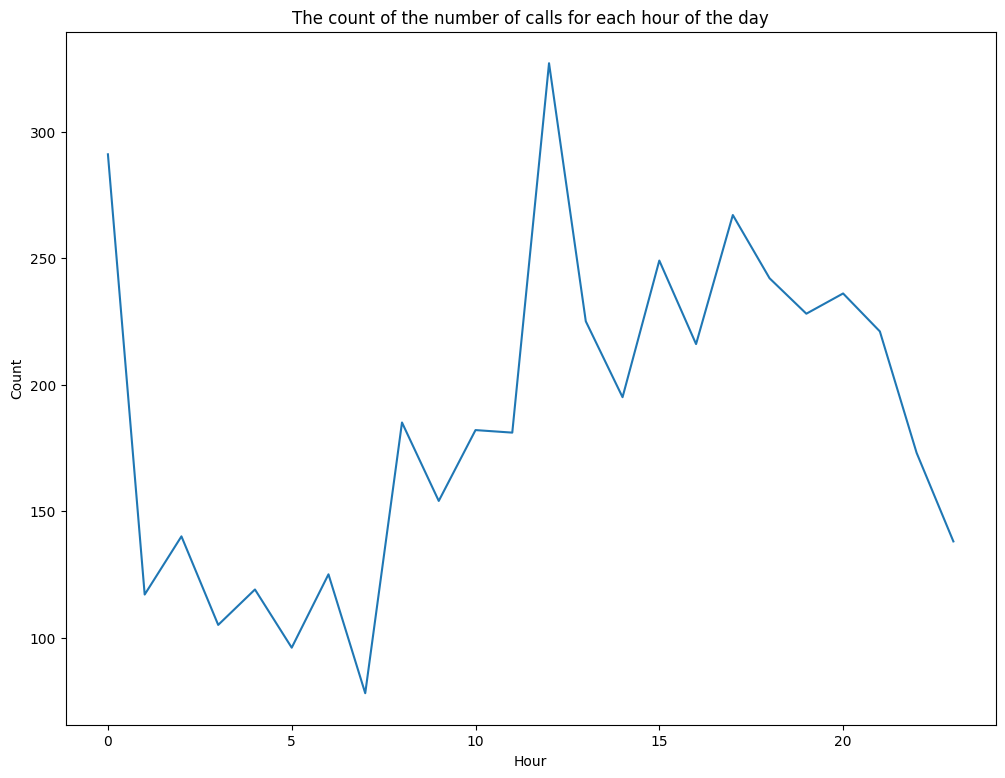

In [89]:
hours = np.arange(0, 24)
count = calls.sort_values("Hour").groupby("Hour").size()
print(count)

plt.plot(hours, count)
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("The count of the number of calls for each hour of the day")
# Leave this for grading purposes.
ax_3d = plt.gca()

In [90]:
grader.check("q2c")

q2c results: All test cases passed!

To better understand the time of day a report occurs, we could **stratify the analysis by the day of the week.** To do this we will use **violin plots** (a variation of a **box plot**).

A violin plot shows an estimated distribution of quantitative data (e.g., distribution of calls by hour) over a categorical variable (day of the week). More calls occur in hours corresponding to the fatter part of each violin; the median hour of all calls in a particular day is marked by the white dot in the corresponding violin.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22964\801389169.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=calls.sort_values("CVDOW"),


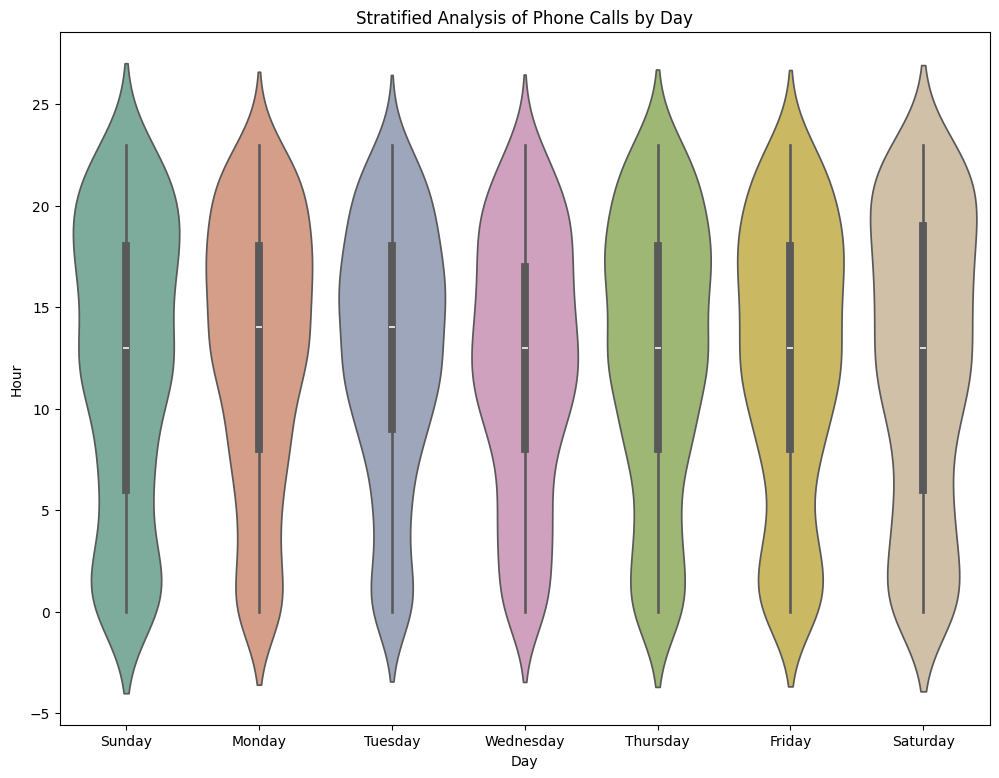

In [91]:
# Run this cell to to generate the plot, no further action is needed

import seaborn as sns
ax = sns.violinplot(data=calls.sort_values("CVDOW"),
                    x="Day", y="Hour",
                    saturation=0.5, palette="Set2")
ax.set_title("Stratified Analysis of Phone Calls by Day");

<!-- BEGIN QUESTION -->

<br>

---
### Question 2d

Based on your line plot and our violin plot above, what observations can you make about the patterns of calls? Here are some dimensions to consider:
* Are there more calls in the day or at night?
* What are the most and least popular times?
* Do call patterns vary by day of the week?


* There are more calls in the day.
* The most popular times and the least popular times are **10:00 AM to 20:00 PM** and **20:00 PM to 5:00 AM** respectively
* Call patterns vary from weekdays to weekends

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

# Part 4: Data Faithfulness vs. Reality
<br>

## Question 3
In this last part of the lab, let's extract the GPS coordinates (latitude, longitude) from the `Block_Location` of each record.

In [92]:
# An example block location entry.
calls.loc[4, 'Block_Location']

'3000 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.85507, -122.26677)'

### Question 3a: Regular Expressions

Use [regular expressions](https://ds100.org/course-notes/regex/regex.html) to create a new `DataFrame` `calls_lat_lon` that has two columns titled `Lat` and `Lon`, containing the respective latitude and longitude of each record in `calls`. You should use the `Block_Location` column to extract the latitude and longitude coordinates.

**Hint**: Check out the `Series.str.extract` [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html?highlight=extract#pandas.Series.str.extract).

In [93]:
calls_lat_lon = pd.DataFrame(calls["Block_Location"].str.extract(r".*\((-*\d+\.\d+), (-*\d+\.\d+)\).*"))
calls_lat_lon = calls_lat_lon.rename(columns={0: "Lat", 1: "Lon"})

calls_lat_lon.head(10)

,Lat,Lon
0,37.86988,-122.27054
1,37.87674,-122.26665
2,37.86206,-122.29346
3,37.87133,-122.28656
4,37.85507,-122.26677
5,37.86397,-122.26036
6,37.87025,-122.29843
7,37.87637,-122.26229
8,37.86725,-122.26326
9,37.86746,-122.29285


In [94]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

---

### Question 3b: Join Tables

Let's include the GPS data into our `calls` data. In the below cell, use `calls_lat_lon` to add two new columns called `Lat` and `Lon` to `calls`.

**Hint 1**: Note that the order of records in `calls` and `calls_lat_lon` are the same. 

**Hint 2**: Another way to achieve our goal could be using `pd.merge`, look through the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) to see how we can merge using the `left_index` and `right_index` arguments.

In [95]:
calls["Lat"] = calls_lat_lon["Lat"]
calls["Lon"] = calls_lat_lon["Lon"]
calls.sample(5)      # random rows

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
4315,22032775,BURGLARY COMMERCIAL,07/18/2022 12:00:00 AM,17:00:00 PM,BURGLARY - COMMERCIAL,1,10/13/2022 04:42:00 PM,"3000 BLOCK TELEGRAPH AVE\nBerkeley, CA\n(37.85...",3000 BLOCK TELEGRAPH AVE,Berkeley,CA,Monday,17,37.85545,-122.25988
1523,22042031,VEHICLE STOLEN,09/09/2022 12:00:00 AM,03:00:00 AM,MOTOR VEHICLE THEFT,5,10/13/2022 04:42:00 PM,"1700 BLOCK RUSSELL ST\nBerkeley, CA\n(37.8557,...",1700 BLOCK RUSSELL ST,Berkeley,CA,Friday,3,37.8557,-122.27425
1376,22044664,THEFT MISD. (UNDER $950),09/23/2022 12:00:00 AM,11:37:00 AM,LARCENY,5,10/13/2022 04:42:00 PM,"1200 BLOCK SAN PABLO AVE\nBerkeley, CA\n(37.88...",1200 BLOCK SAN PABLO AVE,Berkeley,CA,Friday,11,37.88203,-122.29671
4375,22046544,THEFT FELONY (OVER $950),10/03/2022 12:00:00 AM,16:00:00 PM,LARCENY,1,10/13/2022 04:42:00 PM,"2900 BLOCK 7TH ST\nBerkeley, CA\n(37.85292, -1...",2900 BLOCK 7TH ST,Berkeley,CA,Monday,16,37.85292,-122.29172
2439,22041994,THEFT FELONY (OVER $950),09/09/2022 12:00:00 AM,04:25:00 AM,LARCENY,5,10/13/2022 04:42:00 PM,"2300 BLOCK WARD ST\nBerkeley, CA\n(37.86011, -...",2300 BLOCK WARD ST,Berkeley,CA,Friday,4,37.86011,-122.2619


In [96]:
grader.check("q3b")

q3b results: All test cases passed!

<br>

---
### Question 3c: Check for Invalid Values

It seems like every record has valid GPS coordinates. That is, there are no `NaN` values in either column as we can verify below

In [97]:
# Run this cell to obtain fraction of valid lat/lon entries, no further action is needed.
(~calls[["Lat", "Lon"]].isna()).mean()

Lat    1.0
Lon    1.0
dtype: float64

However, a closer examination of the data reveals something else. Here's the first few records of `calls` again:

In [98]:
calls.head(5)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day,Hour,Lat,Lon
0,22036516,THEFT FROM AUTO,08/10/2022 12:00:00 AM,06:10:00 AM,LARCENY - FROM VEHICLE,3,10/13/2022 04:42:00 PM,"Berkeley, CA\n(37.86988, -122.27054)",NaN,Berkeley,CA,Wednesday,6,37.86988,-122.27054
1,22027674,BURGLARY RESIDENTIAL,06/16/2022 12:00:00 AM,20:25:00 PM,BURGLARY - RESIDENTIAL,4,10/13/2022 04:42:00 PM,"1700 BLOCK OXFORD ST\nBerkeley, CA\n(37.87674,...",1700 BLOCK OXFORD ST,Berkeley,CA,Thursday,20,37.87674,-122.26665
2,22023993,VANDALISM,05/25/2022 12:00:00 AM,08:00:00 AM,VANDALISM,3,10/13/2022 04:42:00 PM,"2400 BLOCK 8TH ST\nBerkeley, CA\n(37.86206, -1...",2400 BLOCK 8TH ST,Berkeley,CA,Wednesday,8,37.86206,-122.29346
3,22026547,DISTURBANCE,06/10/2022 12:00:00 AM,21:35:00 PM,DISORDERLY CONDUCT,5,10/13/2022 04:42:00 PM,"1300 BLOCK HEARST AVE\nBerkeley, CA\n(37.87133...",1300 BLOCK HEARST AVE,Berkeley,CA,Friday,21,37.87133,-122.28656
4,22018126,ASSAULT/BATTERY FEL.,04/20/2022 12:00:00 AM,15:31:00 PM,ASSAULT,3,10/13/2022 04:42:00 PM,"3000 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.855...",3000 BLOCK SHATTUCK AVE,Berkeley,CA,Wednesday,15,37.85507,-122.26677


There is another field that tells us whether we have a valid `Block_Location` entry per record - i.e., with GPS coordinates (latitude, longitude) that match the listed block location. What is it?

In the below cell, use the field you found to create a new `DataFrame`, `invalid_block_loc`, that contains only the rows of `calls` that have invalid `Block_Location`. Your new `DataFrame` should have all the same columns of `calls`.

In [99]:
invalid_block_loc = calls[calls["BLKADDR"].isna()]
invalid_block_loc.shape

(14, 15)

In [100]:
grader.check("q3c")

q3c results: All test cases passed!

<br>

---
### Question 3d: Patterns in Invalid Values

Now let's explore if there is a pattern to which types of records have invalid block locations.

We've implemented the plotting code for you below, but read through it and verify you understand what we're doing (we've thrown in a bonus `plt.subplots()` call, documentation [here](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html#stacking-subplots-in-one-direction)).

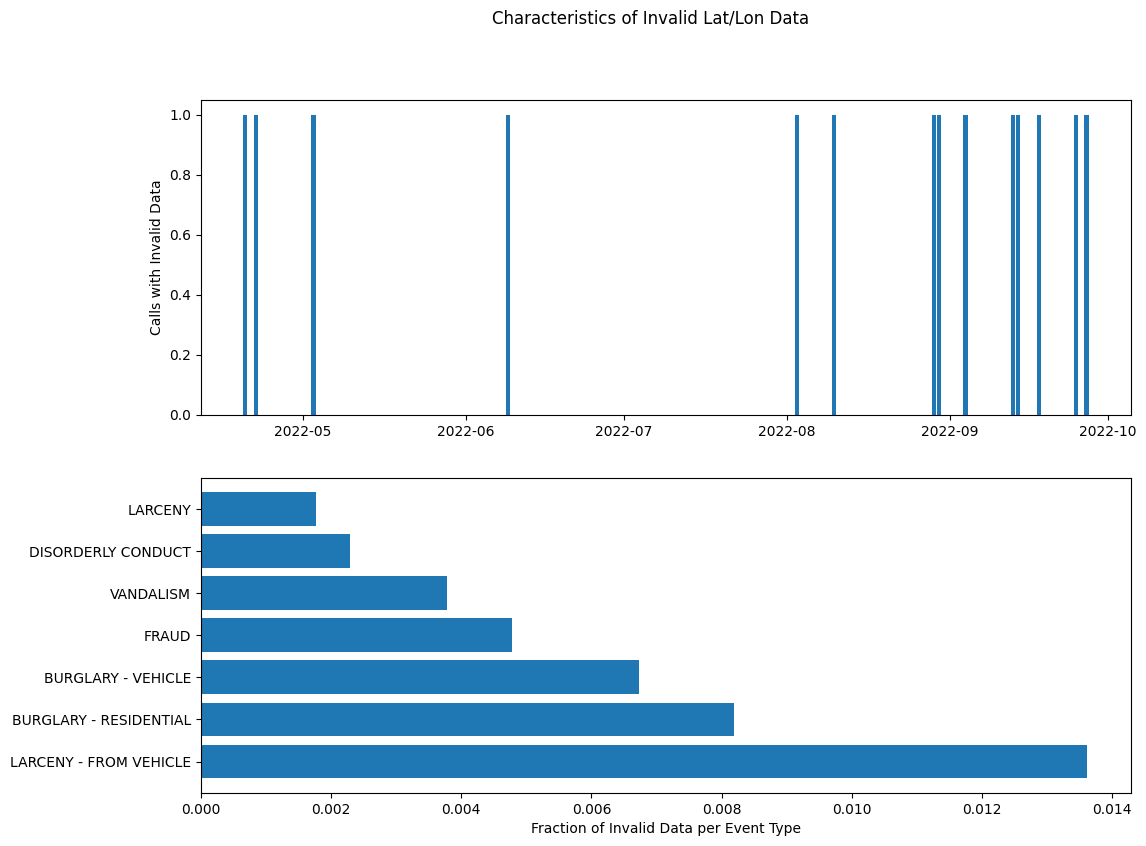

In [101]:
# Run this cell to generate the plot, no further action is needed
missing_by_time = (pd.to_datetime(invalid_block_loc['EVENTDT'], format='%m/%d/%Y %I:%M:%S %p')
                   .value_counts()
                   .sort_index()
                  )
missing_by_crime = (invalid_block_loc['CVLEGEND']
                    .value_counts() 
                    / calls['CVLEGEND'].value_counts()
                   ).dropna().sort_values(ascending=False)

fig, ax = plt.subplots(2)
ax[0].bar(missing_by_time.index, missing_by_time)
ax[0].set_ylabel("Calls with Invalid Data")
ax[1].barh(missing_by_crime.index, missing_by_crime)
ax[1].set_xlabel("Fraction of Invalid Data per Event Type")
fig.suptitle("Characteristics of Invalid Lat/Lon Data")
plt.show()

<!-- BEGIN QUESTION -->


Based on the plots above, are there any patterns among entries that are invalid latitude/longitude data? The dataset information [linked](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) at the top of this notebook may also give more context.

Invaild latitude/longitude cdata onsistently exists, and is usually related to vehicle.

<!-- END QUESTION -->

<br>

---
### Question 3e: Explore

The below cell plots a map of phone calls by GPS coordinates (latitude, longitude); we drop invalid location data.

In [102]:
# Run this cell to generate the interactive plot, no further code is needed.
import folium
import folium.plugins

BERKELEY_COORDINATES = (37.87, -122.28)
berkeley_map = folium.Map(location=BERKELEY_COORDINATES, zoom_start=13)
locs = calls.drop(invalid_block_loc.index)[['Lat', 'Lon']].astype('float').values
heatmap = folium.plugins.HeatMap(locs.tolist(), radius=10)
berkeley_map.add_child(heatmap)

<!-- BEGIN QUESTION -->

Based on the above map, what could be some **drawbacks** of using the location fields in this dataset to draw conclusions about crime in Berkeley? This is an open-ended question. Here are some sub-questions to consider:
* Is campus really the safest place to be?
* Why are all the calls located at street intersections, outdoors, and not within buildings?

* It's hard to say in the US
* Crimes usually occur outside of buildings.

<!-- END QUESTION -->

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Lab 04!

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://forms.gle/owfPCGgnrju1xQEA9). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 04 Coding assignment on Gradescope. Gradescope will automatically submit the PDF from this file to the Lab 04 Written assignment. **There is no need to manually submit Lab 04 Written answers; however, please check that the PDF was generated and submitted correctly**. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [103]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2a results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q3c results: All test cases passed!
